In [31]:
#%% 
# Komplett omtag av new_crypto.py
# TODO: Läs in inflationsdata och gör gemensam df med krypto
# HACK: Påbörjad dummy - fixa resten
# TODO: Inkludera inflationsgraf med grafer ovan

# TODO: Lägg till valet av my own crypto och hantera dem precis som ovan
# TODO: Kopier new_skapa_modeller.ipynb till my_testa_modeller.ipynb
# TODO: Skapa 1 (en) modell för prediction av valfri krypto
# TODO: Testa olika modelltyper i my_skapa_modeller.ipynb

# TODO: Flera sidor?
# TODO: Slutligen: Byt namn till new_crypto.py igen innan publicering
#%%


In [32]:
import pandas as pd
import numpy as np
import streamlit as st
from pandas.tseries.offsets import DateOffset
from binance.client import Client
import datetime

In [33]:

@st.cache_data
def get_data():

    api_key = '2jxiCQ8OIWmU4PZH4xfwKEY9KYerDkSWzwNCqoaMzj41eJgWBsSqA3VYqkt2wmdX'
    api_secret = 'YY1Qj1t0JZrE4tQdaBBxT8iwl2tbFalWp1FHjyZ9selBb6OnQ0Oj8aVdiXO7YLMz'

    client = Client(api_key, api_secret)

    # Hämta handelspar
    symbols = client.get_all_tickers()
    symbols = [symbol for symbol in symbols if symbol['symbol'].endswith('USDT')]

    # Sätt upp en tom lista för att lagra close-priser
    close_prices = {}

    # Ange den tidsram du vill ha för historiska data
    interval = Client.KLINE_INTERVAL_1DAY
    start_time = "2 month ago UTC"

    # Hämta close-priser för alla kryptovalutor
    dates = None
     #add a counter to print a message every 100 symbols
    counter = 0
    for symbol in symbols:   
        try:
            klines = client.get_historical_klines(symbol['symbol'], interval, start_time)
            if dates is None:
                # Extrahera och konvertera tidsstämplar till datum
                dates = [datetime.datetime.fromtimestamp(int(kline[0]) / 1000).strftime('%Y-%m-%d') for kline in klines]
            close_prices[symbol['symbol']] = [float(kline[4]) for kline in klines]
            # every 100 symbols print a message
            if counter % 100 == 0:
                print(f"Hämtade {counter} symboler")
        except Exception as e:
            print(f"Kunde inte hämta data för {symbol['symbol']}: {e}")
        counter += 1
    # Konvertera close_prices-dikten till en pandas DataFrame
    df = pd.DataFrame.from_dict(close_prices, orient='index').transpose()  
    # Lägg till datum som index för DataFrame
    df.index = pd.to_datetime(dates)                                   # type: ignore
    print(df.head())
    return df
df=get_data()


Hämtade 0 symboler
Hämtade 100 symboler
Hämtade 200 symboler
Hämtade 300 symboler
Hämtade 400 symboler
             BTCUSDT  ETHUSDT  BNBUSDT  BCCUSDT  NEOUSDT  LTCUSDT  QTUMUSDT  \
2023-02-07  23240.46  1671.03    333.0      NaN     9.12   100.86     2.961   
2023-02-08  22963.00  1650.43    328.2      NaN     9.18    99.22     2.927   
2023-02-09  21796.35  1545.35    306.2      NaN     8.93    92.05     2.657   
2023-02-10  21625.19  1513.06    305.8      NaN     9.03    93.34     2.745   
2023-02-11  21862.55  1538.51    310.4      NaN     8.92    94.28     2.743   

            ADAUSDT  XRPUSDT  EOSUSDT  ...  GASUSDT  GLMUSDT  PROMUSDT  \
2023-02-07   0.3989   0.4036    1.112  ...    3.759   0.2599      5.82   
2023-02-08   0.3942   0.3975    1.084  ...    3.553   0.2495      5.41   
2023-02-09   0.3622   0.3819    1.044  ...    3.643   0.2516      5.31   
2023-02-10   0.3581   0.3817    1.052  ...    3.397   0.2469      5.03   
2023-02-11   0.3684   0.3833    1.057  ...    3.439 

## Inflation

In [34]:
def add_horizon_columns(inflation, horizons):
    for horizon in horizons:
        inflation['US_inflation_'+str(horizon)] = inflation['US_inflation'].rolling(horizon, 1).mean()
        inflation['SE_inflation_'+str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()
    return inflation


In [35]:

def initiate_data(inflation, df_dates, lang_dict, value_name):
    inflation = inflation.melt(id_vars=['Year'], var_name='month', value_name=value_name)
    inflation['month'] = inflation['month'].map(lang_dict)
    inflation['date'] = pd.to_datetime(inflation['Year'].astype(str) + '-' + inflation['month'].astype(str))
    inflation.set_index('date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(inflation, how='left', left_on='date', right_index=True)
    inflation.set_index('date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


In [36]:
#%%
def get_inflation_data():
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['date'])

    US_inflation = pd.read_html(
        'https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    US_inflation.replace(to_replace=r'^Avail.*$',
                         value=np.nan, regex=True, inplace=True)
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    SE_inflation = pd.read_html(
        'https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6',
                   Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6',
                   Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')

    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10

    US_inflation = initiate_data(US_inflation, df_dates, us_dict, value_name='US_inflation')

    inflations = pd.concat([US_inflation, SE_inflation], axis=1)
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75, 90, 250])
    return inflations



In [37]:

st.title('Performance av Kryptovalutor')

months = int(st.number_input('Please enter the number of previous months', min_value=1, max_value=48, value=12))
n_examine = int(st.number_input('Please enter the number of tickers to examine', min_value=1, max_value=25, value=1))

In [38]:

#%%
def get_returns(df, months):
    # This formula gives the day n months back in time
    #           df.index[-1] - DateOffset(months=months)
    # but we can not be sure it is a trading day so instead:
    old_prices = df[:df.index[-1] - DateOffset(months = months)].tail(1).squeeze()   # n months back in time as a Series
    recent_prices = df.loc[df.index[-1]]
    returns_df = (recent_prices - old_prices) / old_prices
    
    return old_prices.name, returns_df  # date of the old prices and the returns


In [39]:
months=1
date, returns_df = get_returns(df, months)
inflations = get_inflation_data()
winners, losers = returns_df.nlargest(months), returns_df.nsmallest(months)
winners.name,losers.name = 'Best','Worst'

st.table(winners)
st.table(losers)


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [40]:

bestPick = st.selectbox('Pick one for graph', winners.index, index=0)
st.line_chart(df[bestPick]) # type: ignore

worstPick = st.selectbox('Pick one for graph', losers.index, index=0)
st.line_chart(df[worstPick]) # type: ignore

# make a line graph of the inflations
st.line_chart(inflations) # type: ignore
    

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

<Axes: xlabel='date'>

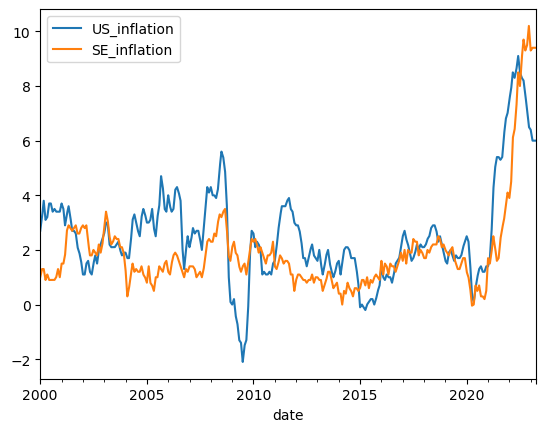

In [44]:
 # pandas line chart inflations
inflations[['US_inflation','SE_inflation']].plot()

In [46]:
winners


SXPUSDT    1.572234
Name: Best, dtype: float64